# Experiments with hidden states

Question, is there a better representation of concepts in hidden states?

Setup: we use DPO setup, with a chosen and rejected string. We then generate a set of hidden states, and compare the hidden states of the chosen and rejected string.

Goal: better generalisation of desired behavuour by changing the internal representation of policy rather than directly changing the policy

  - Hypothesis: rejected and chosen hidden states will - on mean - be best representated as rotations from each other
  - alternate: either mean mass diff (linear) or no repr will be better
  - metric: manual generation getting output while maintaining coherency, prediction other sets of hs

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange

from pathlib import Path

from reprpo.helpers.adapters import set_adapter
from einops import rearrange
from matplotlib import pyplot as plt
from reprpo import silence
from reprpo.gen import generation_test

from reprpo.trainer import mean_with_attention, symlog, mult_with_attention

from tqdm.auto import tqdm
from einops import reduce
from reprpo.trainer import collect_hs, ReprPOConfig, ReprPOTrainer, normalize_output, normalize_per
from datasets import load_dataset

## Load model

In [3]:
from reprpo.models.load import load_model, print_trainable_parameters
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"

## Big adapter
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    lora_dropout=0.0,
    use_rslora=False,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)


model, tokenizer = load_model(model_name, )
# from trl.trainer.utils import peft_module_casting_to_bf16
# peft_module_casting_to_bf16(model)
adapter_name='ReprPO2'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': True})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)
# model

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


## Load adapter

In [4]:
dpo_adapter_f = './output-dir/dpo/DPO'
model.load_adapter(dpo_adapter_f, 'DPO')

_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.ReprPO2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.ReprPO2.weight', 'base_model.model.model.layers.0.mlp.gate_proj.bas

In [5]:
# # QC model and adapter is coherent
# generation_test(model, tokenizer, max_new_tokens=24, system='no yapping', adapter_names=[None, 'DPO'])

## Load DPO dataset

In [6]:
num_samples = 160

In [7]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset),
                N)))
    )

dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset['validation'] = sample(dataset['validation'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
})

## Helpers

In [8]:
import re

def remove_fstr(s):
    # then remove the f'
    s = re.sub(r"f'", "'", s)
    return s.replace('}', '').replace('{', '')

def fhypothesis(equation: str, fmt='.3g', variables: dict = None):
    """
    Evaluate a mathematical hypothesis with variables automatically fetched from the global scope.

    Args:
    - equation: A mathematical equation with variables in curly brackets.
    - fmt: Format specifier for the result.
    Returns:
    - None: Prints the hypothesis and its evaluation.
        
    Usage:    
      a = 0.001
      b = -0.02
      fhypothesis('{a}-{b}')
      fhypothesis('{b}-{a}')
      
      > hypothesis:	 ( a - b )	> 0 ?
      > working:	 ( 0.00 - -0.02 ) = 0.02	> 0	∴ ✅
      > hypothesis:	 ( b - a )	> 0 ?
      > working:	 ( -0.02 - 0.00 ) = -0.02	> 0	∴ ❌

    https://gist.github.com/wassname/3880184763913cb48a58a669e66a2eda
  
    """
    if variables is None:
        variables = globals()
      
    eq_wfmt = equation.replace('}', ':'+fmt+'}')
    eq_pln = remove_fstr(equation)
    res = eval(eq_pln, variables)
    res_fmt = f"{res:{fmt}}"
    sym = '✅' if bool(res>0) else '❌'
    wrk_fmt = "f'( "+eq_wfmt+f" ) = {res_fmt}\t> 0\t∴ {sym}'"
    print(f'hypothesis: ( {eq_pln} )\t> 0 ?')
    print('working:   ', eval(wrk_fmt, variables))
    print()

a = 1e-9
b = -0.02
fhypothesis('{a} - {b}')
fhypothesis('{b} - {a}')

hypothesis: ( a - b )	> 0 ?
working:    ( 1e-09 - -0.02 ) = 0.02	> 0	∴ ✅

hypothesis: ( b - a )	> 0 ?
working:    ( -0.02 - 1e-09 ) = -0.02	> 0	∴ ❌



## Collect HS in DPO way

In [9]:
# reprpo_trainer.is_encoder_decoder

In [10]:
training_args = ReprPOConfig('./output-dir/scratch',
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    gradient_checkpointing=True,
    bf16=True,
    tf32=True,
    max_prompt_length=128,
    max_length=256,
    collection_layers=[10, 20]
                             )
reprpo_trainer = ReprPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)

/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/trl/trainer/dpo_trainer.py:442: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


In [11]:
# QC get dpo catch
dl = reprpo_trainer.get_train_dataloader()
batch = next(iter(dl))
batch['chosen_input_ids'].shape

torch.Size([6, 256])

In [12]:
# QC view a typical input to the model (since the dpo trainer transformes in dataset, concatenating chosen and rejecting along the batch dimension)
batch_concat = reprpo_trainer.concatenated_inputs(
            batch,
            is_encoder_decoder=reprpo_trainer.is_encoder_decoder,
            label_pad_token_id=reprpo_trainer.label_pad_token_id,
            padding_value=reprpo_trainer.padding_value,
            device=reprpo_trainer.accelerator.device,
            max_length=reprpo_trainer.args.max_length,
        )
layer_idx = 0
print(batch_concat.keys())
batch['chosen_input_ids'].shape, batch_concat['concatenated_input_ids'].shape

dict_keys(['concatenated_input_ids', 'concatenated_attention_mask', 'concatenated_labels'])


(torch.Size([6, 256]), torch.Size([12, 256]))

In [13]:
# get batch of hidden states
from reprpo.helpers.torch import clear_mem

@torch.no_grad()
def get_hs(trainer, model, batch):
    model.eval()
    (
        chosen_logps,
        rejected_logps,
        _,
        _,
        _,
        chosen_hs,
        rejected_hs,
        chosen_attn_mask,
        rejected_attn_mask
    ) = trainer.concatenated_forward(trainer.model, batch)
    r = dict(chosen_hs=chosen_hs, rejected_hs=rejected_hs, chosen_logps=chosen_logps, rejected_logps=rejected_logps, chosen_attn_mask=chosen_attn_mask, rejected_attn_mask=rejected_attn_mask)

    # get unprojected hs
    r['chosen_hs_unproj'] = model.lm_head(chosen_hs)
    r['rejected_hs_unproj'] = model.lm_head(rejected_hs)


    # FIXME: label and logits are diff length, maybe need the padding from concat_batch, might be eaiser to just use the concat batch framework for both
    # def get_logps(logits, labels):
    #     logps = []
    #     for layer in range(logits.shape[1]):
    #         all_logps, size_completion = trainer.get_batch_logps(
    #             logits[:, layer],
    #             labels,
    #             label_pad_token_id=trainer.label_pad_token_id,
    #             )
    #         all_logps = all_logps / size_completion
    #     logps.append(all_logps)
    #     r['chosen_logps_unproj'] = torch.stack(logps, dim=1)
    #     return all_logps
    
    # # get fake logp from unproj_hs
    # r['chosen_logps_unproj'] = get_logps(r['chosen_hs_unproj'], batch["chosen_labels"])
    # r['rejection_logps_unproj'] = get_logps(r['rejected_hs_unproj'], batch["rejected_labels"])


    r = {k: v.detach().cpu() for k, v in r.items()}
    clear_mem(trainer)
    
    return r

# turn off adapter

# with reprpo_trainer.null_ref_context():
#     r = get_hs(reprpo_trainer.model, batch)
#     data.append(r)



# policy_chosen_hs, policy_rejected_hs, policy_chosen_logps, policy_rejected_logps = get_hs(reprpo_trainer.model, batch)

In [14]:
# batch

In [15]:
dl = reprpo_trainer.get_train_dataloader()

data = []
for i, batch in enumerate(tqdm(dl)):
    with reprpo_trainer.null_ref_context():
        r = get_hs(reprpo_trainer, reprpo_trainer.model, batch)
        data.append(r)
        if i > 2:
            break

# concat
data = {k: torch.cat([d[k] for d in data], dim=0) for k in data[0].keys()}
data['chosen_hs'].shape

  0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([24, 2, 256, 4096])

In [16]:
model = None
clear_mem(reprpo_trainer)
reprpo_trainer = None
clear_mem()

In [17]:
data.keys()

dict_keys(['chosen_hs', 'rejected_hs', 'chosen_logps', 'rejected_logps', 'chosen_attn_mask', 'rejected_attn_mask', 'chosen_hs_unproj', 'rejected_hs_unproj'])

## Get samples

In [18]:
# get some data samples
layer = 1
C = data['chosen_hs'].half()
R = data['rejected_hs'].half()

C = data['chosen_hs_unproj'].half().softmax(-1)
R = data['rejected_hs_unproj'].half().softmax(-1) # softmax?
CA = data['chosen_attn_mask']
RA = data['rejected_attn_mask']

# unprojected is so large that we need to mean over all tokens
M = 1000
A2 = CA * RA # use both attn masks when comparing?
# minl = A2.sum(-1).min()
C = mult_with_attention(C, A2)[:M, layer]
C = reduce(C, 'b t h -> b h', 'mean')
R = mult_with_attention(R, A2)[:M, layer]
R = reduce(R, 'b t h -> b h', 'mean')

# compare two unrelated sets of samples, that way we have ones that should show the difference and ones that shouldn't show the difference we arel ooking for
n = len(C)//2
print('n', n)
C1 = C[:n] # chosen
R1 = R[:n] # rejected
C2 = C[n:] # unrelated chosen
R2 = R[n:] # unrelated rejected

logratios = data['chosen_logps'] - data['rejected_logps'] # the logp is the log probability (mean per token) of this response, logratios is the log ratio of probs, this should be correlated with the direction we are seeking in the hidden states
logratios1 = logratios[:n]
logratios2 = logratios[n:]
C1.shape

n 12


torch.Size([12, 128256])

### Hypothesis

Is the amplitude of A-B related to the logp?

In [19]:
# ur using abs corrcoef
def acorr(A, B):
    return np.abs(np.corrcoef(A, B, rowvar=True)[0, 1])

def mag_corr(C, R, logratios):
    hs_d = torch.norm(C-R, dim=-1, p=2) # get magnitude of the difference
    corr = acorr(hs_d, logratios.exp())
    # note that after flipping we ruin the order, and they should be uncorrelated except for the middle one if it's odd
    corr_null = acorr(hs_d, logratios.flip(0).exp())
    fhypothesis('{corr} / {corr_null} - 1', variables=dict(corr=corr, corr_null=corr_null))

print('does the magnitude of the hs_unproj correlate with the prob ratio (across batches)? if so it\'s a good repr')
print("should pass")
mag_corr(C1, R1, logratios1)

print("should pass")
mag_corr(C2, R2, logratios2)

print("expect not to be significantly diff")
mag_corr(C2, R2, logratios1)

print("expect not to be significantly diff")
mag_corr(C1, R1, logratios2)

# FAIL

does the magnitude of the hs_unproj correlate with the prob ratio (across batches)? if so it's a good repr
should pass
hypothesis: ( corr / corr_null - 1 )	> 0 ?
working:    ( 0.414 / 0.0193 - 1 ) = 20.5	> 0	∴ ✅

should pass
hypothesis: ( corr / corr_null - 1 )	> 0 ?
working:    ( 0.106 / 0.338 - 1 ) = -0.687	> 0	∴ ❌

expect not to be significantly diff
hypothesis: ( corr / corr_null - 1 )	> 0 ?
working:    ( 0.585 / 0.337 - 1 ) = 0.733	> 0	∴ ✅

expect not to be significantly diff
hypothesis: ( corr / corr_null - 1 )	> 0 ?
working:    ( 0.183 / 0.32 - 1 ) = -0.427	> 0	∴ ❌



is the red line outside the distribution of null correlations?


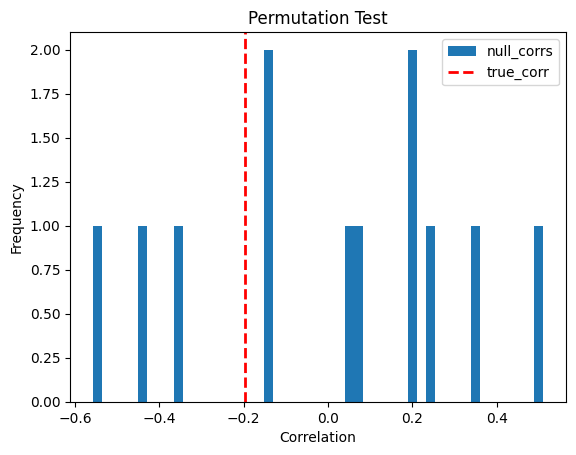

P-value: 0.692


In [20]:
def permutation_test(C, R, logratios, n_permutations=100):

    n_permutations = min(n_permutations, len(logratios))

    true_corr = np.corrcoef(
        torch.norm(C - R, dim=-1), 
        logratios)[0, 1]
    
    null_corrs = []
    for _ in range(n_permutations):
        perm_logratios = logratios[torch.randperm(len(logratios))]
        null_corrs.append(np.corrcoef(torch.norm(C - R, dim=-1), perm_logratios)[0, 1])
    
    plt.hist(null_corrs, bins=50, label='null_corrs')
    plt.axvline(true_corr, color='r', linestyle='dashed', linewidth=2, label='true_corr')
    plt.title('Permutation Test')
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    p_value = (np.sum(np.abs(null_corrs) >= np.abs(true_corr)) + 1) / (n_permutations + 1)
    print(f"P-value: {p_value:.3f}")

print('is the red line outside the distribution of null correlations?')
permutation_test(C1, R1, logratios1)
# FAIL

In [21]:
from scipy import stats

def non_linear_correlation(C, R, logratios):
    distances = torch.norm(C - R, dim=-1)
    logratios = logratios.cpu().numpy()
    
    print('p should be low, corr should be large [-1, 1]')
    corr, p = stats.spearmanr(distances, logratios)
    print(f"Spearman correlation: {corr:.2f} {p:.2f}")
    corr, p = stats.kendalltau(distances, logratios)
    
    print(f"Kendall's tau: {corr:.2f} p={p:.2f}")

    print()

non_linear_correlation(C1, R1, logratios1)

non_linear_correlation(C2, R2, logratios2)


print('should fail')
non_linear_correlation(C2, R2, logratios1)

print('should fail')
non_linear_correlation(C2, R2, logratios1)

# FAIL

p should be low, corr should be large [-1, 1]
Spearman correlation: 0.11 0.73
Kendall's tau: 0.09 p=0.74

p should be low, corr should be large [-1, 1]
Spearman correlation: -0.17 0.59
Kendall's tau: -0.12 p=0.64

should fail
p should be low, corr should be large [-1, 1]
Spearman correlation: -0.13 0.70
Kendall's tau: -0.09 p=0.74

should fail
p should be low, corr should be large [-1, 1]
Spearman correlation: -0.13 0.70
Kendall's tau: -0.09 p=0.74



In [22]:
def cosine_similarity_correlation(C, R, logratios):
    cos_sim = F.cosine_similarity(C, R, dim=-1)  # [batch, layers, tokens]

    corrs = np.corrcoef(cos_sim, logratios, rowvar=True)[0, 1] 
    
    return np.abs(corrs)

c111 = cosine_similarity_correlation(C1, R1, logratios1)
c222 = cosine_similarity_correlation(C2, R2, logratios2)
c112 = cosine_similarity_correlation(C1, R1, logratios2)
c221 = cosine_similarity_correlation(C2, R2, logratios1)

print('cosine similarity of related ones should be higher than unrelated')
fhypothesis('{c111} / {c112} - 1')
fhypothesis('{c222} / {c221} - 1')
fhypothesis('{c111} / {c221} - 1')
fhypothesis('{c222} / {c112} - 1')

# SUCCESS! so for hs_unproj.softmax(-1) is ti more correlated than unrelate sets )


cosine similarity of related ones should be higher than unrelated
hypothesis: ( c111 / c112 - 1 )	> 0 ?
working:    ( 0.471 / 0.211 - 1 ) = 1.23	> 0	∴ ✅

hypothesis: ( c222 / c221 - 1 )	> 0 ?
working:    ( 0.424 / 0.351 - 1 ) = 0.21	> 0	∴ ✅

hypothesis: ( c111 / c221 - 1 )	> 0 ?
working:    ( 0.471 / 0.351 - 1 ) = 0.344	> 0	∴ ✅

hypothesis: ( c222 / c112 - 1 )	> 0 ?
working:    ( 0.424 / 0.211 - 1 ) = 1.01	> 0	∴ ✅



In [23]:
1/0

ZeroDivisionError: division by zero

In [ ]:
@torch.no_grad()
def rotation_test(C, R, logratios):
    def optimal_rotation(A, B):
        corr_matrix = torch.mm(A.t(), B)
        Q, _ = torch.linalg.qr(corr_matrix)
        return Q
    
    R_opt = optimal_rotation(C, R)
    R_rotated = torch.matmul(R, R_opt.t())
    
    a= C - R
    b = C - R_rotated

    a -= a.mean(dim=-1, keepdim=True)
    b -= b.mean(dim=-1, keepdim=True)
    # a /= torch.norm(a, dim=0, p=2, keepdim=True)
    # b /= torch.norm(b, dim=0, p=2, keepdim=True)

    original_diff = torch.norm(a, p=2)
    rotated_diff = torch.norm(b, p=2)
    
    print(f"Original difference: {original_diff}")
    print(f"Rotated difference: {rotated_diff}")
    print(f"Improvement: {(original_diff - rotated_diff) / original_diff * 100:.2f}%")
    
    c = np.corrcoef(torch.norm(a, dim=-1, p=2).mean(dim=-1)[:, layer], logratios)[0, 1]
    r = np.corrcoef(torch.norm(b, dim=-1, p=2).mean(dim=-1)[:, layer], logratios)[0, 1]
    print(f"Correlation before rotation: {c:.2f}")
    print(f"Correlation after rotation: {r:.2f}")
    
    return R_opt, R_rotated

# maybe I should softmax first?
R_opt, R_rotated = rotation_test(C1[:1], R1[:1], logratios1[:1].exp())
print()

# watch out for the mem error here
# R_opt, R_rotated = rotation_test(C2, R2, logratios2.exp())

In [ ]:

R_opt, R_rotated = rotation_test(C1, R1, logratios1)
print()
R_opt, R_rotated = rotation_test(C2, R2, logratios2)

In [ ]:
# uncorrelated vars
R_opt, R_rotated = rotation_test(C1, R1, logratios2)
print()
R_opt, R_rotated = rotation_test(C2, R2, logratios1)

### Visualize

In [ ]:


# def centered_scale(x):
#     """move center from 0 to 0.5, and scale from -1, 1 to 0, 1"""
#     x /= np.nanmax(np.abs(x)) * 2
#     x += 1/2.
#     return x

def imshow_hw(im):
    # note we assume it's centered around 0
    assert im.mean()/im.std() < 1e-3
    vmax = max(np.abs(im.min()), np.abs(im.max()))
    plt.imshow(im, cmap='seismic_r', interpolation='none', vmin=-vmax, vmax=vmax, aspect='auto', origin='upper')
    # axis_off()
    plt.xlabel('hidden state')
    plt.ylabel('batch')
    plt.colorbar()

def axis_off():
    plt.xticks([])
    plt.yticks([])

def stats(d):
    d = d[np.isfinite(d)]
    print(f'min: {d.min():.2f}, mean: {d.mean():.2f}, max: {d.max():.2f}, std: {d.std():.2f}')

def scale(x):
    x = symlog(x)
    np.nan_to_num(x, copy=False)
    x /= np.nanmax(np.abs(x))
    return x

In [ ]:
data.keys()

Below we define A1, B1, A2, B2 and we can use them to test various hypothesis

A1 and B1 are paired and opposite. Likewise A2 and B2 are paired and opposite.

But A1 and A2 should not differ along our chosen axis, and likewise B1 and B2 should not differ along our chosen axis.

In [ ]:

# # 'B, L, T, H' 
# # reduce the hidden states, choosing a layer, thaking the mean of tokens after the attention mask is applied
# layer = 2
# C = mean_with_attention(data['chosen_hs'], data['chosen_attn_mask'])[:, layer].cpu()
# R = mean_with_attention(data['rejected_hs'], data['rejected_attn_mask'])[:, layer].cpu()

# n = len(C)//2
# C1 = C[:n] # chosen
# R1 = R[:n] # rejected
# C2 = C[n:] # unrelated chosen
# R2 = R[n:] # unrelated rejected


# C1.shape, R2.shape

In [ ]:
plt.figure(figsize=(10,10)) 
plt.subplot(3,1,1)
imshow_hw(symlog(C1-R1))
plt.title('A1-B1')
plt.subplot(3,1,2)
imshow_hw(symlog(C1-C2))
plt.title('A1-A2')
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,3)
imshow_hw(symlog(R1-R2))
plt.title('B1-B2')


In [ ]:
batch['chosen_input_ids'][-1]
batch['chosen_attention_mask'][-1]

In [ ]:

# reduce and plot
def Rd(X):
    X = normalize_per(X, [-2, -1])
    X = normalize_per(X, 0)
    X = reduce(X, 'b l t h -> b l t h', 'mean')[-1, layer]
    return symlog(X)


plt.figure(figsize=(10,10)) 
plt.subplot(3,1,1)

imshow_hw((Rd(C1-R1)))
plt.ylabel('token')
plt.title('A1-B1')
plt.subplot(3,1,2)
imshow_hw((Rd(C1-C2)))
plt.ylabel('token')
plt.title('A1-A2')
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,3)
imshow_hw((Rd(R1-R2)))
plt.ylabel('token')
plt.title('B1-B2')


In [ ]:
C = mult_with_attention(data['chosen_hs'], data['chosen_attn_mask'])[:, layer].cpu().mean(0)
R = mult_with_attention(data['rejected_hs'], data['rejected_attn_mask'])[:, layer].cpu().mean(0)

n = len(C)//2
C1 = C[:n] # chosen
R1 = R[:n] # rejected
C2 = C[n:] # unrelated chosen
R2 = R[n:] # unrelated rejected


plt.figure(figsize=(10,10)) 
plt.subplot(3,1,1)
imshow_hw(symlog(C1-R1))
plt.ylabel('token')
plt.title('A1-B1')
plt.subplot(3,1,2)
imshow_hw(symlog(C1-C2))
plt.ylabel('token')
plt.title('A1-A2')
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,3)
imshow_hw(symlog(R1-R2))
plt.ylabel('token')
plt.title('B1-B2')

# TODO try norm by neuron


In [ ]:
plt.figure(figsize=(10,10)) 
plt.subplot(3,1,1)
imshow_hw(symlog(C1))
plt.ylabel('token')
plt.title('A1')
plt.subplot(3,1,2)
imshow_hw(symlog(C2))
plt.ylabel('token')
plt.title('A2')
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,3)
imshow_hw(symlog(R2))
plt.ylabel('token')
plt.title('B2')

In [ ]:
def mse(x, y):
    return ((x-y)**2).mean()

# this is what we expect, the related ones are less different than the unrelated ones
mse(C1, R1), mse(C1, C2), mse(R1, R2)

## Hypotheses

### Principal Component Analysis (PCA):
Apply PCA to (A - B) pairs. If differences are primarily rotational, most variance should be explained by a few components.

In [ ]:
from sklearn.decomposition import PCA

def pca_exp_var(X, Y):
    diffs = (X - Y).numpy()
    s = diffs.std()
    diffs /= s
    # axis 1, norm each neuron across the batch
    # diffs /= diffs.std(1, keepdims=True) + 1e-3
    pca = PCA(n_components=5)
    pca.fit(diffs)
    r = pca.explained_variance_ratio_.mean()
    return r


# 
e_a1b1, e_a1a2, e_a1b2, e_b1b2 = pca_exp_var(C1, R1), pca_exp_var(C1, C2), pca_exp_var(C1, R2), pca_exp_var(R1, R2)

print('PCA explained variance ratio')
print('A1-B1', e_a1b2)
fhypothesis('{e_a1b1} - {e_a1a2}')
fhypothesis('{e_a1b1} - {e_a1b2}')
fhypothesis('{e_a1a2} - {e_a1b2}')
e_a1b2, e_a1a2, e_a1b2, e_b1b2

In [ ]:
> hypothesis: ( a - b )	> 0 ?
> working:    ( 0.00 - -0.02 )= 0.02	> 0	∴ ✅
> hypothesis: ( b - a )	> 0 ?
> working:    ( -0.02 - 0.00 )= -0.02	> 0	∴ ❌

so this fails... but now that I think about it, the A-B difference is smaller and a lot harder to predict, even by pca, so I might need a baseline

but also 8% variance explained is really not much

### Frobenius Norm Comparison:
Compare ||A - B||_F with ||A - RB||_F where R is the optimal rotation. The latter should be significantly smaller if rotations capture most differences.

In [ ]:
def norm_comparison(A, B):
    diff_norm = torch.norm(A - B)
    U, _, V = torch.svd(torch.mm(A, B.t()))
    R = torch.mm(U, V.t())
    rot_diff_norm = torch.norm(A - torch.mm(R, B))
    return diff_norm, rot_diff_norm


diff_norm, rot_diff_norm= norm_comparison(C1, R1)
print(diff_norm, rot_diff_norm)
hyp('diff_norm>rot_diff_norm')

# result: insiginificant difference?

In [ ]:

diff_norm, rot_diff_norm= norm_comparison(C1, R2)
diff_norm, rot_diff_norm

Angle Histogram:
Plot histogram of angles between corresponding columns of A and B. Should be concentrated if differences are mainly rotational.

In [ ]:
def angle_histogram(A, B):
    cos_sims = torch.sum(A * B, dim=0) / (torch.norm(A, dim=0) * torch.norm(B, dim=0))
    angles = torch.acos(cos_sims) * 180 / np.pi
    plt.hist(angles.numpy())
    plt.show()

angle_histogram(A, B)